## Imports and Environment

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# set BEFORE tf import
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def reset_random_seeds(new_seed):
   os.environ['PYTHONHASHSEED']=str(new_seed)
   tf.random.set_seed(new_seed)
   np.random.seed(new_seed)
   random.seed(new_seed)

reset_random_seeds(SEED)

## Data Loading

In [2]:
df_orig = pd.read_csv('./creditcard_2023.csv', index_col=0)
df_train, df_test = train_test_split(df_orig, test_size=0.1, random_state=SEED)

## Check GPU

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow IS using the GPU")
else:
  print("TensorFlow IS NOT using the GPU")

TensorFlow IS using the GPU


## Model Creation

In [4]:
model = Sequential([
    Input(shape=(28,)),
    Dense(30, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

## Prepare Data and Pipeline

In [5]:
# X and y split
X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']

In [6]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

In [7]:
# set up pipeline
preprocessing = ColumnTransformer([
        ('drop', 'drop', ['Amount']),
    ], remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

## Set Up Hyperparameters

In [8]:
param_dict = {
    'model__epochs': 5,
    'model__batch_size': 64,
    'model__steps_per_epoch': len(X_train) // 64,
    'model__validation_data': (preprocessing.fit_transform(X_valid), y_valid),
    'model__shuffle': True,
}

## Model Training

In [9]:
pipe.fit(X_train, y_train, **param_dict)

Epoch 1/5
7196/7196 [==============================] - 64s 9ms/step - loss: 0.0672 - precision: 0.9873 - recall: 0.9630 - val_loss: 0.0310 - val_precision: 0.9923 - val_recall: 0.9877
Epoch 2/5
7196/7196 [==============================] - 61s 9ms/step - loss: 0.0214 - precision: 0.9932 - recall: 0.9953 - val_loss: 0.0155 - val_precision: 0.9936 - val_recall: 0.9987
Epoch 3/5
7196/7196 [==============================] - 60s 8ms/step - loss: 0.0124 - precision: 0.9955 - recall: 0.9990 - val_loss: 0.0106 - val_precision: 0.9950 - val_recall: 0.9991
Epoch 4/5
7196/7196 [==============================] - 62s 9ms/step - loss: 0.0091 - precision: 0.9967 - recall: 0.9996 - val_loss: 0.0081 - val_precision: 0.9967 - val_recall: 1.0000
Epoch 5/5
7196/7196 [==============================] - 57s 8ms/step - loss: 0.0074 - precision: 0.9972 - recall: 0.9997 - val_loss: 0.0068 - val_precision: 0.9970 - val_recall: 0.9996


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Amount'])])),
                ('model',
                 <keras.engine.sequential.Sequential object at 0x0000025F214A84C0>)])

## Model Evaluation (Validation)

In [10]:
hist = pipe.named_steps['model'].history.history

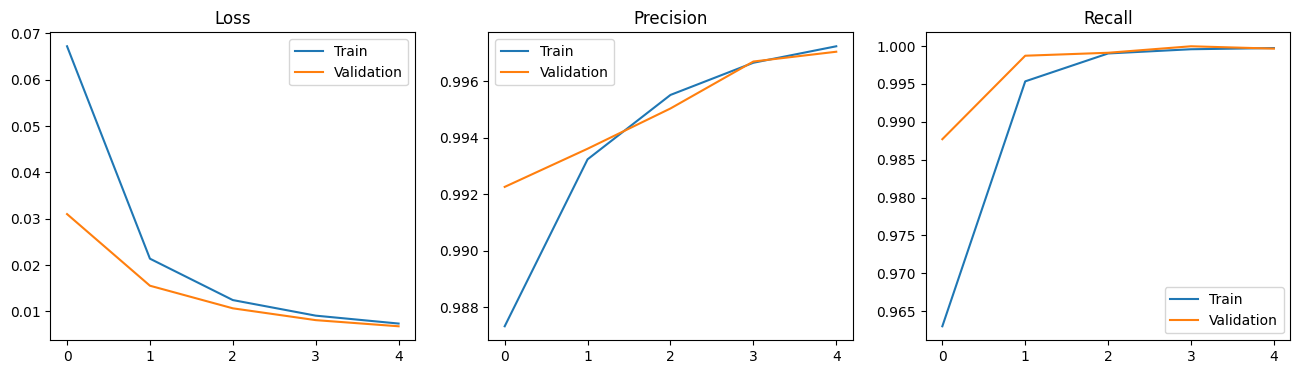

In [11]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].set_title('Loss')
sns.lineplot(hist['loss'], label='Train', ax=ax[0])
sns.lineplot(hist['val_loss'], label='Validation', ax=ax[0])

ax[1].set_title('Precision')
sns.lineplot(hist['precision'], label='Train', ax=ax[1])
sns.lineplot(hist['val_precision'], label='Validation', ax=ax[1])

ax[2].set_title('Recall')
sns.lineplot(hist['recall'], label='Train', ax=ax[2])
sns.lineplot(hist['val_recall'], label='Validation', ax=ax[2])
plt.show()

## Model Evaluation (Test)

In [12]:
X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

In [13]:
y_pred = pipe.predict(X_test)

1777/1777 [==============================] - 5s 3ms/step


In [14]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

precision.update_state(y_test, y_pred)
print(f'Test Precision: {precision.result().numpy()}')

recall.update_state(y_test, y_pred)
print(f'Test Recall: {recall.result().numpy()}')

Test Precision: 0.9973714351654053
Test Recall: 0.999718964099884
